## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup

I imported in a dataset provided by IMDB's interface. Scraping the data from their website turned out to be unnecessary.

This database is still missing the cost to make movie and the profit. We found a database containing the production costs, worldwide and domestic gross income. This information is not given to us in a file unfortunately like the previous dataset was, so we will have to employ some datascraping to pull this data off the website. We are grabbing our data from https://www.the-numbers.com/movie/budgets/all
I defined 2 functions to ease the load since I need to run a separate iteration of this script in order to catch the first page due to it having a unique url. 

In [85]:
'''Takes in the URL as an argument, and returns the chart that the movies are in.'''
def html_parse(url):
    html_page = requests.get(url, timeout=5)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    chart = soup.find(id = 'page_filling_chart')
    movie_container = chart.findAll('tr') #grabs all movie entries on the page and puts into a list
    return movie_container

In [86]:
'''Takes in the row containing the movie title, profits, release date, and costs and returns a list of those.'''
def movie_extract(data_container):
        release_date = data_container[1].text #release date
        movie_name = data_container[2].text #name of movie
        prod_budget = data_container[3].get_text(strip=True) #production budget
        gross_dom = data_container[4].get_text(strip=True) #gross domestic 
        gross_world = data_container[5].get_text(strip=True) #gross worldwide
        #we want to strip all of the newline junk off of the text.
        
        return [release_date, movie_name, prod_budget, gross_dom, gross_world]

This is the initial run of the function due to the URL being unique for the very first page.

In [87]:
df = pd.DataFrame(columns = ['Release_Date', 'Movie_Name', 'Production_Budget', 'Gross_Domestic', 'Gross_Worldwide'])
url = "https://www.the-numbers.com/movie/budgets/all"
movie_container = html_parse(url)

#for loop here to iterate through the list of movies in movie_container
for u in range(1,101):
    data_container = movie_container[u].findAll('td')

    data_series = movie_extract(data_container)
    
    a_series = pd.Series(data_series, index = df.columns)
    df = df.append(a_series, ignore_index=True)

Iterates through all the pages utilizing URL hacking to find all of the pages.

In [88]:
for i in range(2,61): #change 4 to 61 for all
    url = "https://www.the-numbers.com/movie/budgets/all/{}01".format(i)
    movie_container = html_parse(url)

    #for loop here to iterate through the list of movies in movie_container
    for u in range(1,101): 
        if i == 60 and u == 44:
            break
        data_container = movie_container[u].findAll('td') #the tag we want to look through

        data_series = movie_extract(data_container)
        
        a_series = pd.Series(data_series, index = df.columns)
        df = df.append(a_series, ignore_index=True)


In [90]:
df.to_csv('zippedData/movieMoney.csv') #saving it to a CSV so I don't have to scrape everytime I want to look at the data

In [4]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
0,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,797,800,564"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,063,875","$1,045,663,875"
2,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,396,099,202"
3,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,065,478,084"
4,"Apr 25, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,359,754"
...,...,...,...,...,...
5938,Unknown,Red 11,"$7,000",$0,$0
5939,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5940,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5941,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


Putting in the datascrubbing + merging that was done by Simran around here I guess

Things we want to look at.
1) Day of release affects profit
2) Genre of movie affects profit
3) Actors in movie affects profit
4) Season of release affects profit
5) international sales
6) average number of movies to make
7) number of reviews and gross #scatter plot




1) Genre of movie affects profit
    a) season for the genre to be released
    boxplot
    b) What genres succeed internationally
    boxplot x- genres, y profit
2) Number of reviews and profit
    a)scatter plot, x is number of votes,y is profit #see if number of views is what matters
        i) color code the review rating, 10-8 green, 7-5 yellow etc...
    b) scatter plot, x is number of votes, y is production cost #see if higher production costs get more views
3) How does the number of movies created by a studio affect the average profit
    a)do franchises do better

Starting to look at and scrub the data. The first step is going to be converting the datatypes into a usable form. 

In [2]:
df = pd.read_csv('zippedData/movieMoney.csv', index_col=0)

In [3]:
df.dtypes

Release_Date         object
Movie_Name           object
Production_Budget    object
Gross_Domestic       object
Gross_Worldwide      object
dtype: object

In [4]:
df['Movie_Name'] = df['Movie_Name'].astype('string')

df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

df['Production_Budget'] = df['Production_Budget'].str.replace('$', '')
df['Production_Budget'] = df['Production_Budget'].str.replace(',', '')
df['Production_Budget'] = df['Production_Budget'].astype(int)

df['Gross_Domestic'] = df['Gross_Domestic'].str.replace('$', '')
df['Gross_Domestic'] = df['Gross_Domestic'].str.replace(',', '')
df['Gross_Domestic'] = df['Gross_Domestic'].astype(int)

df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace('$', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace(',', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].astype('int64')

df.sort_values('Release_Date', inplace=True, ascending=False) #sort by release date, most recent on top
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


The second step is to remove the films from the dataframe that haven't happened yet. The next step is to count the number of films that have no budget or not profit to see if they can be removed from the dataset without any problems.

Here we are removing films based on time. We've decided that we're only going to look at recent movies, films created in 1980 and on, films that haven't come out yet, and also removing any films that came out this year as well, due to Coronavirus dramatically changing what the movie industry looks like. Movies will likely be back to "normal" by the time that we would finish with filming and editing a movie so we'll be able to use traditional data.

Alongside that, we'll be looking for any duplicates.

In [5]:
print(df[df.duplicated()]) #looking for any duplicated rows

Empty DataFrame
Columns: [Release_Date, Movie_Name, Production_Budget, Gross_Domestic, Gross_Worldwide]
Index: []


In [6]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


There doesn't seem to be any duplicated rows in our movie money dataframe.

In [7]:
df_filtered = df[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31')] 
print(df_filtered.head(), df_filtered.tail())

     Release_Date         Movie_Name  Production_Budget  Gross_Domestic  \
3640   2019-12-31         The Grudge           10000000        21216148   
2404   2019-12-27      The Gentlemen           22000000        36296854   
1293   2019-12-25       Little Women           42000000       108095955   
305    2019-12-25  Spies in Disguise          100000000        66757013   
287    2019-12-25               1917          100000000       159227644   

      Gross_Worldwide  
3640         49503265  
2404        111800189  
1293        209065465  
305         166083937  
287         358403321        Release_Date          Movie_Name  Production_Budget  Gross_Domestic  \
5332   1980-02-01             The Fog            1100000        21445318   
5680   1980-01-01              Maniac             350000        10000000   
4727   1980-01-01        Terror Train            3500000         8000000   
1713   1980-01-01  Lion of the Desert           35000000         1500000   
4166   1980-01-01     Dre

We're filtered down our money dataset to only contain the films that we are planning on looking at by date.

In [17]:
title_akas_df.drop(title_akas_df[title_akas_df['region'] != 'US'].index, inplace=True) #holding onto this code incase I want it

1) Genre of movie affects profit a) season for the genre to be released boxplot b) What genres succeed internationally boxplot x- genres, y profit

This is where we'll be making our genre graph. Will be coming back to this later. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Our final dataset containing the movie budget information. 

In [3]:
df = pd.read_csv('Final_Data/Final_Movie_Budget.csv', index_col=0)
df.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,"Sep 23, 1994",The Shawshank Redemption,25000000.0,28241469.0,2.841706e+07,both,175591.0
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,"Jul 11, 2008",The Dark Knight,185000000.0,533720947.0,1.000743e+09,both,467021804.0
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,160000000.0,292576195.0,8.355246e+08,left_only,535700000.0
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,"Oct 15, 1999",Fight Club,65000000.0,37030102.0,1.008345e+08,both,63804388.0
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,"Sep 10, 1994",Pulp Fiction,8000000.0,107928762.0,2.129119e+08,both,104983148.0


We're creating the profit column here, adjusting for inflation for the year it came out to today's currency (2020)

In [4]:
df['Gross_Worldwide'] = df['Gross_Worldwide'] * (2020 - df['year'])*1.0322
df['Gross_Domestic'] = df['Gross_Domestic']* (2020- df['year'])*1.0322
df['Production_Budget'] = df['Production_Budget'] * (2020- df['year'])*1.0322
df['Gross_Foreign_Only'] = df['Gross_Foreign_Only'] * (2020- df['year'])*1.0322
df['Profit'] = (df['Gross_Worldwide'] - df['Production_Budget']) #create the profit column

Making sure that our dateset only contains the movies that fall within the timeframe we're looking at. Should've been done earlier, but if anything was missed it'll be caught here. We will also create another column for the season the movie was released in. Winter: Jan-Mar, Spring: Apr-Jun, Summer: July-Sept, Fall: Oct-Dec

In [5]:
season_dict = {1.0 : 'Winter', 2.0 : 'Winter' , 3.0 : 'Spring',
              4.0 : 'Spring', 5.0 : 'Spring', 6.0 : 'Summer',
              7.0 : 'Summer', 8.0 : 'Summer', 9.0 : 'Fall',
              10.0 : 'Fall', 11.0 : 'Fall', 12.0 : 'Winter',
              'NaN' : 'NaN'}
#may want to adjust the months back 1 so December isn't a fall month. 
df['Release_Date'] = pd.to_datetime(df.Release_Date, errors='coerce') #convert into datetimes
df.sort_values(by='Release_Date') #sort by release date

df['Month'] = df['Release_Date'].dt.month
df['Season'] = df['Release_Date'].dt.month.map(season_dict)
df.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit,Month,Season
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,1994-09-23,The Shawshank Redemption,6.709300e+08,7.579220e+08,7.626343e+08,both,4.712371e+06,9.170432e+07,9.0,Fall
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,2008-07-11,The Dark Knight,2.291484e+09,6.610881e+09,1.239560e+10,both,5.784719e+09,1.010412e+10,7.0,Summer
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,1.651520e+09,3.019971e+09,8.624285e+09,left_only,5.529495e+09,6.972765e+09,7.0,Summer
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,1999-10-15,Fight Club,1.408953e+09,8.026719e+08,2.185709e+09,both,1.383037e+09,7.767556e+08,10.0,Fall
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,1994-09-10,Pulp Fiction,2.146976e+08,2.896506e+09,5.713960e+09,both,2.817454e+09,5.499262e+09,9.0,Fall


want to drop region, runtime, movie_name, 

In [6]:
df_filter = df.loc[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31')] #select the right dates
df_filter.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit,Month,Season
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,1994-09-23,The Shawshank Redemption,6.709300e+08,7.579220e+08,7.626343e+08,both,4.712371e+06,9.170432e+07,9.0,Fall
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,2008-07-11,The Dark Knight,2.291484e+09,6.610881e+09,1.239560e+10,both,5.784719e+09,1.010412e+10,7.0,Summer
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,1.651520e+09,3.019971e+09,8.624285e+09,left_only,5.529495e+09,6.972765e+09,7.0,Summer
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,1999-10-15,Fight Club,1.408953e+09,8.026719e+08,2.185709e+09,both,1.383037e+09,7.767556e+08,10.0,Fall
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,1994-09-10,Pulp Fiction,2.146976e+08,2.896506e+09,5.713960e+09,both,2.817454e+09,5.499262e+09,9.0,Fall


In [7]:
genre_raw_df = pd.read_csv('zippedData/title.basics.tsv', low_memory=False, sep='\t')

drop anything not a "movie"


In [8]:
genre_raw_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


We're merging the genre data into the dataset that contains the rest of our information, including votes, money, and release dates. 

In [9]:
df_filter = df_filter.merge(genre_raw_df[['tconst', 'genres']], how='inner', on='tconst')

In [10]:
df_filter['genres'] = df_filter['genres'].apply(lambda x: x.split(','))
genre_df_col = df_filter.columns.drop('genres')

In [11]:
genre_df = df_filter['genres'].apply(pd.Series) \
    .merge(df_filter, right_index = True, left_index=True)\
    .drop(['genres'], axis=1)\
    .melt(id_vars=genre_df_col, value_name = 'genre')\
    .drop('variable', axis=1)\
    .dropna()
genre_order = genre_df['genre'].unique()

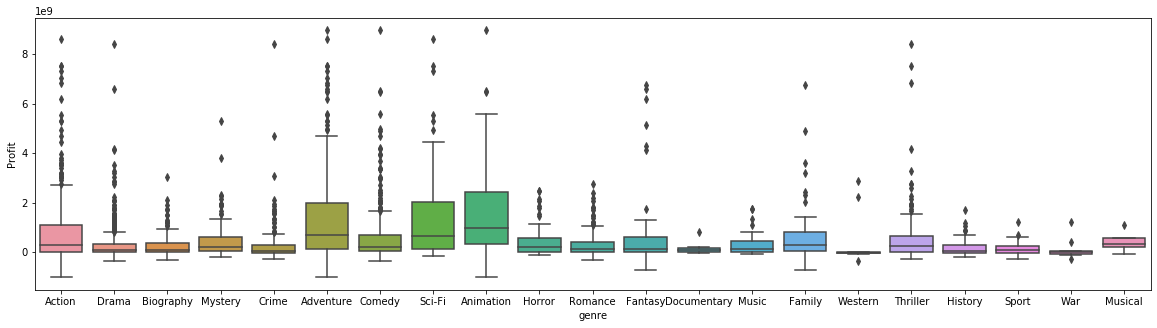

In [12]:
plt.figure(figsize=(20,5))
sns.boxplot(x='genre', y='Profit', data=genre_df,
            order=genre_order)

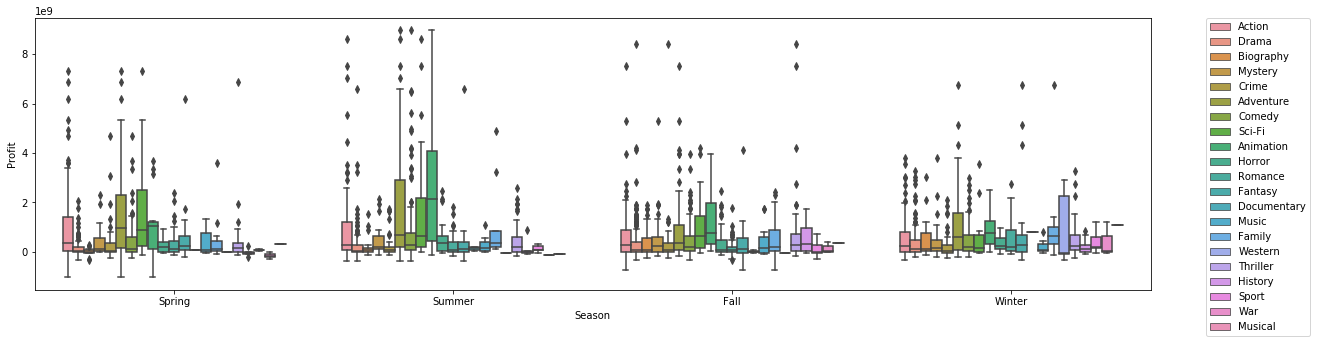

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(x='Season', y='Profit', hue='genre', data=genre_df,
           order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})
#idk depends on the number of genres really

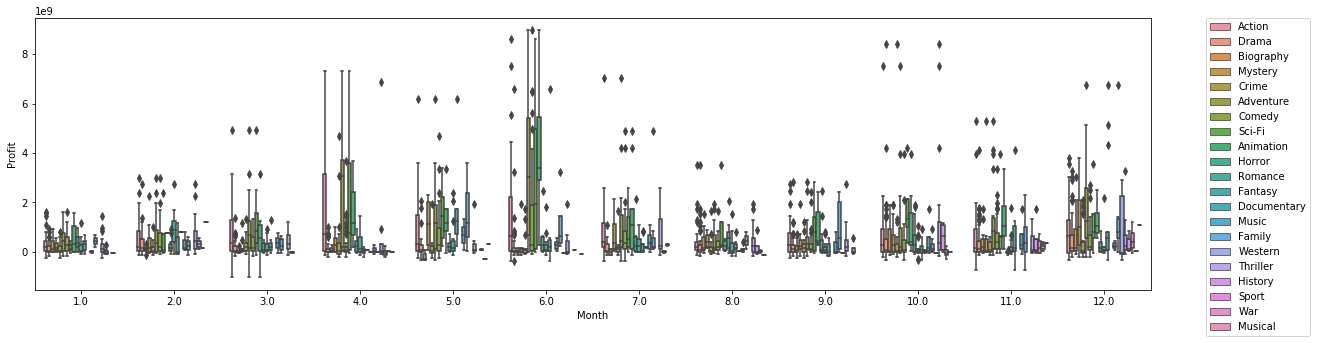

In [14]:
plt.figure(figsize=(20,5))
sns.boxplot(x='Month', y='Profit', hue='genre', data=genre_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})

<Figure size 360x1440 with 0 Axes>

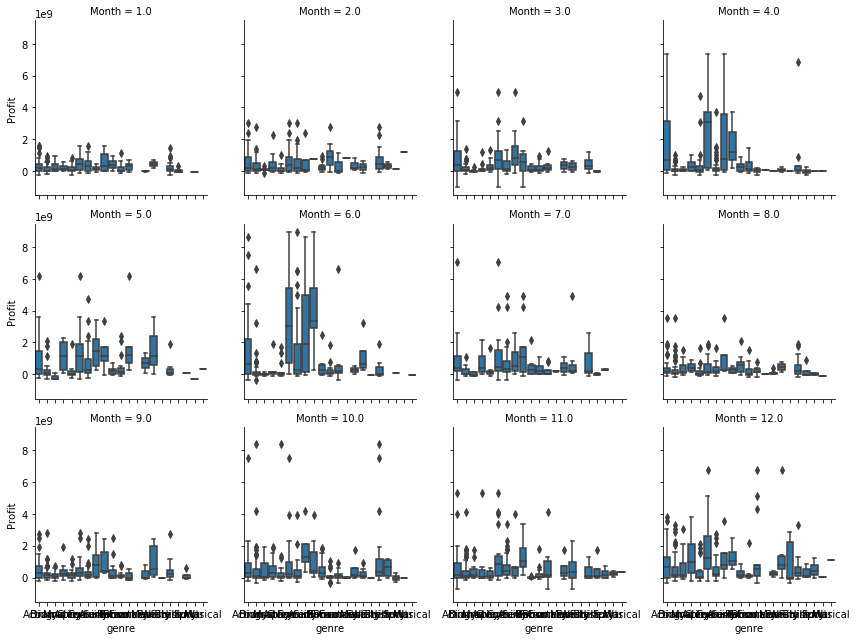

In [15]:
plt.figure(figsize=(5,20))
g = sns.FacetGrid(genre_df, col="Month", col_wrap=4, margin_titles=True)
g.map(sns.boxplot, "genre", "Profit", order=genre_order);

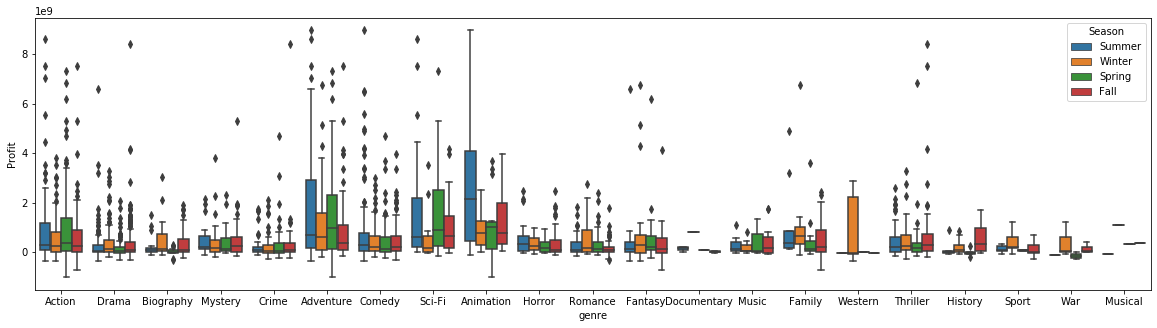

In [16]:
plt.figure(figsize=(20,5))
sns.boxplot(x='genre', y='Profit', hue='Season', data=genre_df)

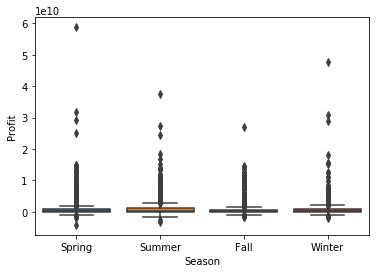

In [17]:
sns.boxplot(x='Season', y='Profit', data=df_filter,
               order=['Spring', 'Summer', 'Fall', 'Winter'])

We are looking at if the number of votes is related to the amount of money that is made by the film.

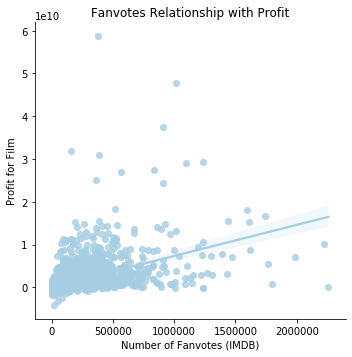

In [18]:
sns.set_palette(sns.color_palette('Paired'))
lmplot1 = sns.lmplot(x='numVotes', y='Profit', data=df_filter)
lmplot1.set(xlabel = "Number of Fanvotes (IMDB)", ylabel='Profit for Film', title='Fanvotes Relationship with Profit')

Here we are going to be looking at if there is a relationship between how much money is spent on a film and if more money spent on the film results in more votes, which we've assumed to mean more views.

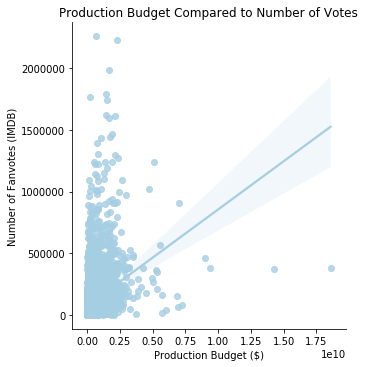

In [29]:
df_prod_out = df_filter[(df_filter['numVotes'] > 250)]
lmplot2 = sns.lmplot(y='numVotes', x='Production_Budget', data=df_prod_out)
lmplot2.set(xlabel = "Production Budget ($)", ylabel='Number of Fanvotes (IMDB)', 
            title='Production Budget Compared to Number of Votes')


In [20]:
df_prod_out.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit,Month,Season,genres
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,1994-09-23,The Shawshank Redemption,6.709300e+08,7.579220e+08,7.626343e+08,both,4.712371e+06,9.170432e+07,9.0,Fall,[Drama]
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,2008-07-11,The Dark Knight,2.291484e+09,6.610881e+09,1.239560e+10,both,5.784719e+09,1.010412e+10,7.0,Summer,"[Action, Crime, Drama]"
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,1.651520e+09,3.019971e+09,8.624285e+09,left_only,5.529495e+09,6.972765e+09,7.0,Summer,"[Action, Adventure, Sci-Fi]"
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,1999-10-15,Fight Club,1.408953e+09,8.026719e+08,2.185709e+09,both,1.383037e+09,7.767556e+08,10.0,Fall,[Drama]
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,1994-09-10,Pulp Fiction,2.146976e+08,2.896506e+09,5.713960e+09,both,2.817454e+09,5.499262e+09,9.0,Fall,"[Crime, Drama]"


And finally, looking at the relationship directly. Production value and profit.

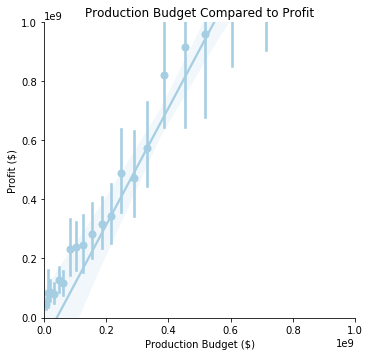

In [60]:
lmplot3 = sns.lmplot(y='Profit', x='Production_Budget',x_bins=25, data=df_prod_out)
lmplot3.set(xlabel = "Production Budget ($)", ylabel='Profit ($)', 
            title='Production Budget Compared to Profit',
               xlim=(0,1000000000),
               ylim=(-1000000,1000000000))

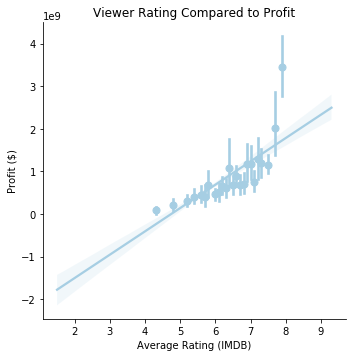

In [61]:
lmplot4 = sns.lmplot(y='Profit', x='averageRating', x_bins = 25, data=df_prod_out)
lmplot4.set(xlabel = "Average Rating (IMDB)", ylabel='Profit ($)', title='Viewer Rating Compared to Profit')

3) How does the number of movies created by a studio affect the average profit

In [62]:
df_filter.sort_values(by=['Release_Date', 'studio'])

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit,Month,Season,genres
2844,NaN,1980.0,Maniac,tt2103217,89,6.1,34321.0,17.0,17.0,1980-01-01,Maniac,1.445080e+07,4.128800e+08,4.128800e+08,both,0.000000e+00,3.984292e+08,1.0,Winter,"[Horror, Thriller]"
2858,NaN,1980.0,Dressed to Kill,tt0080661,104,7.1,33579.0,31.0,31.0,1980-01-01,Dressed to Kill,2.683720e+08,1.317046e+09,1.317046e+09,both,0.000000e+00,1.048674e+09,1.0,Winter,"[Mystery, Thriller]"
3638,NaN,1980.0,Lion of the Desert,tt0081059,173,8.4,13529.0,30.0,30.0,1980-01-01,Lion of the Desert,1.445080e+09,6.193200e+07,6.193200e+07,both,0.000000e+00,-1.383148e+09,1.0,Winter,"[Biography, Drama, History]"
3875,NaN,1980.0,Terror Train,tt0081617,97,5.9,9410.0,31.0,31.0,1980-01-01,Terror Train,1.445080e+08,3.303040e+08,3.303040e+08,both,0.000000e+00,1.857960e+08,1.0,Winter,"[Horror, Mystery, Thriller]"
2145,NaN,1980.0,The Fog,tt0080749,89,6.8,61621.0,56.0,56.0,1980-02-01,The Fog,4.541680e+07,8.854343e+08,8.854550e+08,both,2.072658e+04,8.400382e+08,2.0,Winter,"[Horror, Thriller]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,NaN,2019.0,Midway,tt6924650,138,6.7,50616.0,39.0,39.0,2019-11-07,Midway,1.032200e+08,5.867727e+07,1.289921e+08,both,7.031483e+07,2.577210e+07,11.0,Fall,"[Action, Adventure, Drama]"
4654,NaN,2017.0,The Islands,tt5304664,89,5.7,722.0,6.0,6.0,2019-12-06,The Islands,3.715920e+06,0.000000e+00,0.000000e+00,both,0.000000e+00,-3.715920e+06,12.0,Winter,[Adventure]
3167,NaN,2006.0,Black Christmas,tt0454082,84,4.6,24291.0,25.0,25.0,2019-12-13,Black Christmas,7.225400e+07,1.507179e+08,2.677558e+08,both,1.170379e+08,1.955018e+08,12.0,Winter,[Horror]
1351,NaN,1994.0,Little Women,tt3281548,135,7.9,113879.0,48.0,48.0,2019-12-25,Little Women,1.127162e+09,2.900993e+09,5.610732e+09,both,2.709739e+09,4.483569e+09,12.0,Winter,"[Drama, Romance]"


Here we are going to group our films by what year they came out, and by what studio created them. We're looking at the number of films released by a studio that year, how much money it made, and alongside that, the costs to create it.

In [63]:
studio_df = df_filter.loc[df_filter['studio'] != 'NaN'].groupby(['year', 'studio']).agg({
                                                'Movie_title' : 'count', 
                                               'numVotes' : 'median',
                                               'Production_Budget' : 'median',
                                               'Gross_Domestic' : 'median',
                                               'Gross_Worldwide' : 'median',
                                               'Profit' : 'median'})

In [64]:
studio_df.head()

Movie_title  numVotes  Production_Budget  Gross_Domestic  \
year   studio                                                             
2010.0 ATO               1   16548.0        129025000.0    2.105553e+07   
       Anch.             5   30248.0         46449000.0    1.723568e+06   
       App.              1   45497.0         98059000.0    3.688745e+07   
       BV                7   79213.0        825760000.0    6.497739e+08   
       CBS               2   57051.0        283855000.0    1.843652e+08   

               Gross_Worldwide        Profit  
year   studio                                 
2010.0 ATO        2.345350e+07 -1.055715e+08  
       Anch.      2.561843e+07 -4.867122e+06  
       App.       5.448604e+07 -4.357296e+07  
       BV         9.566321e+08  5.985348e+08  
       CBS        2.664105e+08 -1.744455e+07

[Text(0, 0.5, 'Median Profit ($)'),
 Text(0.5, 0, 'Number of Movies in a Year by a Studio'),
 Text(0.5, 1.0, 'Median Profit per Year By Number of Releases')]

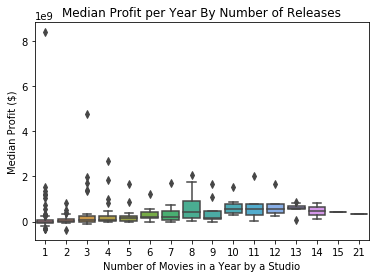

In [65]:
boxplot1 = sns.boxplot(x='Movie_title', y='Profit', data=studio_df)
boxplot1.set(xlabel = "Number of Movies in a Year by a Studio", ylabel='Median Profit ($)', title='Median Profit per Year By Number of Releases')

[Text(0, 0.5, 'Median Fanvotes ($)'),
 Text(0.5, 0, 'Number of Movies in a Year by a Studio'),
 Text(0.5, 1.0, 'Median Fanvotes per Year By Number of Releases')]

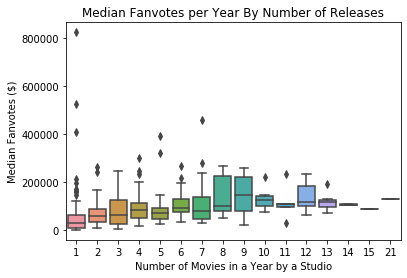

In [66]:
boxplot2 = sns.boxplot(x='Movie_title', y='numVotes', data=studio_df)
boxplot2.set(xlabel = "Number of Movies in a Year by a Studio", ylabel='Median Fanvotes ($)', title='Median Fanvotes per Year By Number of Releases')

Looks like the best amount of movies to release in a year around 10? 